In [1]:
from torch import cos, sin, Tensor
from typing import List, Tuple
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import Bernoulli, Normal
from simulator import Simulator

# Simulator 

In this document I will produce a prototype stochastic simulator for the path of a marine vessel. The simulator is a toy, based neither on real physics or real data. It does, however, provide a method to generate fake data upon which I will build a proof-of-principle probabilistic trajectory predictor.

## Rationale

For a real ship, the relevant variables are complicated, depending on everything from hull form to water depth. 

For my simulator I will only consider rudder angle and velocity. These will be chosen stochastically, with some small assumptions (velocity will tend positive, rudder angle will tend straight). Every ship will be initialised in the same position and with the same orientation. This latter point isn't too ridiculous, since it just amounts to centering the coordinate system over the boat at initialisiation, and hence doesn't actually result in a loss of generality if we assume that the trajectory is invariant to the initial position. This won't always be the case with real ships, which for example, are unlikely to sail into land, but can be a good approximation in some restrictive cases, such as at deep sea.

In [2]:
import torch
from torch import Tensor, cos, sin
from typing import List, Tuple

def arc_trace_centered(velocity: Tensor, 
              rudder_angle: Tensor, 
              time_steps: int = 10,
              record_resolution: int = 1) -> Tuple[Tensor, Tensor]:
    """A function for tracing an arc-segment of a ship's trajectory.
    Assumes a coordinate frame which is initially centred on the ship, and rotated so that the
    ship is starts with a vertical orientation.

    Toy model which assumes the ship always travels along circular arcs where
    the arc radius depends purely on rudder angle. When the rudder is straight
    takes the limiting case of travelling in a straight line.

    Args:
        velocity (Tensor): the ship's velocity for the present timestep.
        rudder_angle (Tensor): the rudder angle relative to the ship's orientation.
        time_step (float): amount of time over which to integrate trajectory.
        record_resolution (float): the time resolution with which the position of ship is recorded.

    Returns:
        A tuple containing 
        1. The n new points in the ships trajectory, in an nx2 tensor.
        2. The new orientation as a scalar torch.tensor.
    """
    assert torch.abs(rudder_angle) <= torch.pi/5, "abs(rudder_angle) must be <= pi/5"
    assert time_steps%record_resolution==0, "record_resolution must be a factor of time_steps"
    
    # assume a 100 unit turn_radius at 45 degree rudder
    turn_radius = 100/torch.tan(rudder_angle)
    total_steps = time_steps//record_resolution
    position_deltas = []
    distances_moved = velocity*record_resolution*torch.arange(1,total_steps+1)
    if rudder_angle==0:
        zero_x = torch.zeros_like(distances_moved)
        return torch.stack([zero_x, distances_moved], dim=1)
    else:
        subtended_angles = distances_moved/turn_radius
        new_positions_x = turn_radius*cos(subtended_angles)-turn_radius
        new_positions_y = turn_radius*sin(subtended_angles)
        position_deltas = torch.stack([new_positions_x, new_positions_y],dim=1)

        return position_deltas, subtended_angles[-1]
    
def translate_and_rotate_arc(init_position, init_orientation, position_deltas, orientation_delta):
    """Given an arc in space, 

    Args:
        init_position (_type_): _description_
        init_orientation (_type_): _description_
        position_deltas (_type_): _description_
        orientation_delta (_type_): _description_

    Returns:
        _type_: _description_
    """
    rotation_matrix = torch.tensor([[cos(init_orientation), -sin(init_orientation)],
                                    [sin(init_orientation), cos(init_orientation)]])
    
    rotated_position_deltas = torch.einsum('ij,kj -> ki', rotation_matrix, position_deltas)

    new_positions = init_position + rotated_position_deltas
    new_orientation = init_orientation + orientation_delta

    return new_positions, new_orientation


def arc_trace(orientation: Tensor, 
              position: Tensor,
              velocity: Tensor, 
              rudder_angle: Tensor, 
              time_steps: int = 10,
              record_resolution: int = 1) -> Tuple[Tensor, Tensor]:
    """
    Generalisation of arc_trace_centered to account for uncentered and rotated coordinate axes.

    Traces an arc-segment of a ship's trajectory.
    Toy model which assumes the ship always travels along circular arcs where
    the arc radius depends purely on rudder angle. When the rudder is straight
    takes the limiting case of travelling in a straight line. 
    
    Args:
        orientation (Tensor): the ship's angle relative to coordinate axes. 
        velocity (Tensor): the ship's velocity for the present timestep.
        rudder_angle (Tensor): the rudder angle relative to the ship's orientation.
        trajectory (List[Tensor]): the trajectory so far, as a list of position coordinates.
        time_step (float): amount of time over which to integrate trajectory.
        record_resolution (float): the time resolution with which the position of ship is recorded.

    Returns:
        A tuple containing 
        1. The new points in the ships trajectory, after time_step has elapsed. The number of points
        recorded depends on record_resolution.
        2. The new orientation at the end of the arc of the trajectory.
    """
    position_deltas, orientation_delta = arc_trace_centered(velocity, rudder_angle, 
                                                            time_steps, record_resolution)

    new_positions, new_orientation = translate_and_rotate_arc(position, orientation, 
                                                              position_deltas, orientation_delta)

    return new_positions, new_orientation


In [6]:
def trajectory_plot(trajectory, ax):
    trajectory = trajectory.numpy()
    trajectory_x = trajectory[:,0]
    trajectory_y = trajectory[:,1]
    ax.plot(trajectory_x, trajectory_y)
    ax.set_aspect('equal')

In [18]:
def arc_trace_center_plot(velocity, rudder_angle, time_step, resolution, ax):
    trajectory, _ = arc_trace_centered(velocity, rudder_angle, time_step, resolution)
    trajectory_plot(trajectory, ax)

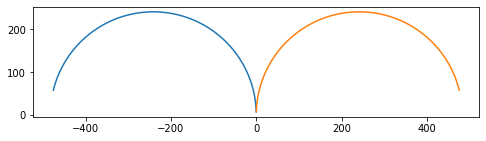

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))

arc_trace_center_plot(torch.tensor(7),torch.tensor(torch.pi/8),100, 1, ax)
arc_trace_center_plot(torch.tensor(7),-torch.tensor(torch.pi/8),100, 1, ax)

In [22]:
def arc_trace_plot(orientation, position, ax):
    traj,_ = arc_trace(orientation, position, torch.tensor(7),torch.tensor(torch.pi/8), 100, 1)
    trajectory_plot(traj, ax)

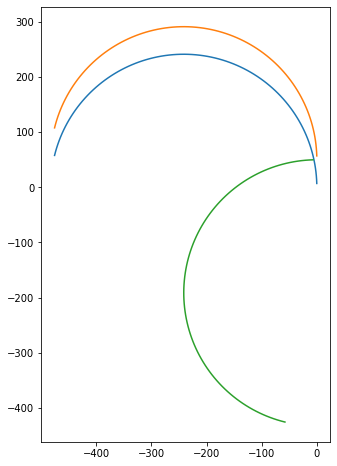

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

arc_trace_plot(torch.tensor(0), torch.tensor([0.,0.]), ax)
arc_trace_plot(torch.tensor(0), torch.tensor([0.,50.]), ax)
arc_trace_plot(torch.tensor(torch.pi/2), torch.tensor([0.,50.]), ax)

In [97]:
theta = torch.tensor(torch.pi/4)
rot = torch.tensor([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

In [101]:
positions = torch.rand(5,2)

In [104]:
torch.einsum('ij,kj -> ki', rot, positions)

tensor([[ 0.3469,  0.8740],
        [-0.0094,  0.8986],
        [ 0.5579,  0.7132],
        [ 0.3125,  1.0383],
        [ 0.3135,  0.3632]])

In [112]:
(rot@(positions.T)).T

tensor([[ 0.3469,  0.8740],
        [-0.0094,  0.8986],
        [ 0.5579,  0.7132],
        [ 0.3125,  1.0383],
        [ 0.3135,  0.3632]])

In [123]:
arc_trace(torch.tensor(0), torch.tensor([0,0]),torch.tensor(7),torch.tensor(torch.pi/8),100)[0]

/tmp/ipykernel_1459/3610858227.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert torch.abs(torch.tensor(rudder_angle)) <= torch.pi/5, "abs(rudder_angle) must be <= pi/5"


tensor([[-1.0147e-01,  6.9990e+00],
        [-4.0582e-01,  1.3992e+01],
        [-9.1277e-01,  2.0974e+01],
        [-1.6219e+00,  2.7937e+01],
        [-2.5326e+00,  3.4878e+01],
        [-3.6441e+00,  4.1788e+01],
        [-4.9556e+00,  4.8664e+01],
        [-6.4658e+00,  5.5499e+01],
        [-8.1735e+00,  6.2287e+01],
        [-1.0077e+01,  6.9023e+01],
        [-1.2176e+01,  7.5701e+01],
        [-1.4467e+01,  8.2315e+01],
        [-1.6948e+01,  8.8860e+01],
        [-1.9619e+01,  9.5331e+01],
        [-2.2476e+01,  1.0172e+02],
        [-2.5517e+01,  1.0803e+02],
        [-2.8739e+01,  1.1424e+02],
        [-3.2141e+01,  1.2036e+02],
        [-3.5718e+01,  1.2637e+02],
        [-3.9468e+01,  1.3228e+02],
        [-4.3388e+01,  1.3808e+02],
        [-4.7474e+01,  1.4377e+02],
        [-5.1724e+01,  1.4933e+02],
        [-5.6133e+01,  1.5477e+02],
        [-6.0697e+01,  1.6007e+02],
        [-6.5414e+01,  1.6524e+02],
        [-7.0279e+01,  1.7028e+02],
        [-7.5287e+01,  1.751

In [51]:
max(Normal(0,5).sample((1000,)))

tensor(15.5167)

In [54]:
torch.tensor([0,0]).reshape(1,2)

tensor([[0, 0]])

In [2]:
simulator = Simulator()
wobbly_simulator = Simulator(wobbliness = 0.2)

In [5]:
wobbly_simulator()

(tensor([ -20.8011, 1077.0355]),
 tensor(-0.0168),
 tensor([[   0.0000,    0.0000],
         [   0.0000,    7.0000],
         [   0.0000,   14.0000],
         ...,
         [ -20.6472, 1086.1854],
         [ -20.7241, 1081.6105],
         [ -20.8011, 1077.0355]]))

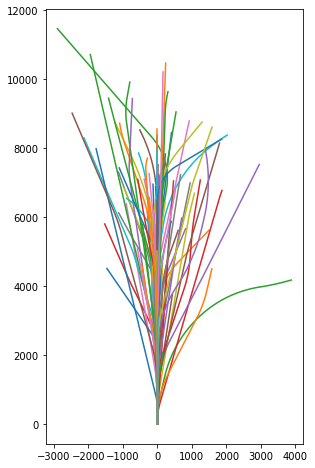

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(100):
    trajectory_plot(simulator()[-1], ax)

In [3]:
end_points = [simulator()[0].numpy() for _ in range(100)]

In [4]:
end_points_x = np.array([point[0] for point in end_points])
end_points_y = np.array([point[1] for point in end_points])

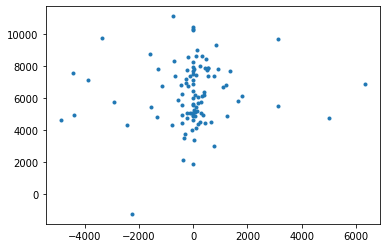

In [5]:
plt.plot(end_points_x, end_points_y, '.')